In [2]:
!pip install -q kaggle
!pip install transformers
!pip install unidecode
!pip install torch
!pip install tqdm
!pip install transformers
!pip install livelossplot==0.5.4

     |████████████████████████████████| 2.6 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 40.0 MB/s 
     |████████████████████████████████| 636 kB 40.0 MB/s 
     |████████████████████████████████| 895 kB 43.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 241 kB 4.9 MB/s 


In [3]:
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
from google.colab import files
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, BertConfig, AutoModel, BertTokenizerFast
from livelossplot import PlotLosses
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import time
random.seed(int(time.time()))
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn, utils
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import RandomSampler
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabib3b","key":"817d7e169db4cbef867b22907320144c"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c home-depot-product-search-relevance

  0% 0.00/4.74M [00:00<?, ?B/s]
100% 4.74M/4.74M [00:00<00:00, 78.6MB/s]
  0% 0.00/2.51M [00:00<?, ?B/s]
100% 2.51M/2.51M [00:00<00:00, 170MB/s]
  0% 0.00/105k [00:00<?, ?B/s]
100% 105k/105k [00:00<00:00, 109MB/s]
 33% 9.00M/27.2M [00:00<00:00, 76.4MB/s]
100% 27.2M/27.2M [00:00<00:00, 108MB/s] 
  0% 0.00/227k [00:00<?, ?B/s]
100% 227k/227k [00:00<00:00, 216MB/s]
 81% 28.0M/34.8M [00:00<00:00, 76.5MB/s]
100% 34.8M/34.8M [00:00<00:00, 116MB/s] 


In [7]:
!ls

attributes.csv.zip	      relevance_instructions.docx  test.csv.zip
kaggle.json		      sample_data		   train.csv.zip
product_descriptions.csv.zip  sample_submission.csv.zip


In [8]:
att_df= pd.read_csv('attributes.csv.zip')
desc_df= pd.read_csv('product_descriptions.csv.zip')
df = pd.read_csv('train.csv.zip', encoding='latin-1')
test_df = pd.read_csv('test.csv.zip',encoding='latin-1')


In [9]:
desc_df = desc_df.fillna(0)
df = df.fillna(0)

test_df = test_df.fillna(0)
att_df = att_df.fillna(0)

desc_df['product_uid'] = desc_df['product_uid'].astype(np.int64)
df['product_uid'] = df['product_uid'].astype(np.int64)
test_df['product_uid'] = test_df['product_uid'].astype(np.int64)
att_df['product_uid'] = att_df['product_uid'].astype(np.int64)

In [10]:
df.sample(2)

,id,product_uid,product_title,search_term,relevance
4780,14936,102602,Pavestone RockWall 6 in. x 18 in. Palomino Lar...,fast block wall,2.00
17428,53731,113977,Avanti Pro Removal Project Set (4-Piece),4 paint brush,1.33


In [11]:
np.min(df['relevance'].tolist()), np.max(df['relevance'].tolist())

(1.0, 3.0)

In [12]:
unique_values = pd.unique(df['relevance']).tolist()
num_of_unique_values = len(unique_values)
sorted(unique_values), num_of_unique_values

([1.0, 1.25, 1.33, 1.5, 1.67, 1.75, 2.0, 2.25, 2.33, 2.5, 2.67, 2.75, 3.0], 13)

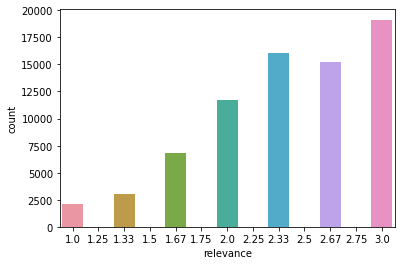

In [13]:
# np.bincount(df['relevance'].tolist(), minlength = num_of_unique_values)
ax = sns.countplot(x="relevance", data=df)


In [14]:
mapping = {1.25: 1.33, 1.5: 1.67, 1.75: 2.0, 2.25: 2.33, 2.5: 2.67, 2.75: 3.0}
df['relevance'] = df['relevance'].apply(lambda relevance: mapping[relevance] if relevance in mapping else relevance)

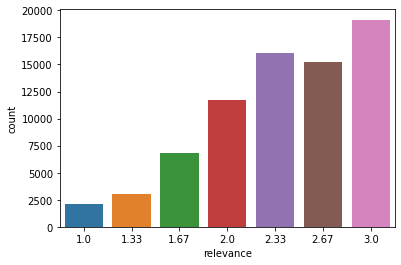

In [15]:
ax = sns.countplot(x="relevance", data=df)

In [16]:
df.describe()

,id,product_uid,relevance
count,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,2.381773
std,64016.573650,30770.774864,0.533978
min,2.000000,100001.000000,1.000000
25%,57163.500000,115128.500000,2.000000
50%,113228.000000,137334.000000,2.330000
75%,168275.500000,166883.500000,3.000000
max,221473.000000,206650.000000,3.000000


In [14]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
MAX_SEARCH_TERM_LENGTH = 10
MAX_TITLE_LENGTH = 30

In [15]:
def tokenize(text, max_length):

  encoded = tokenizer.encode_plus(
        text,
        max_length = max_length,
        pad_to_max_length=True,
        truncation=True
    )
  
  
  return pd.Series([encoded['input_ids'], encoded['attention_mask']])
  


In [16]:
df[['product_title_tokens', 'product_title_mask']] = df['product_title'].progress_apply(lambda text: tokenize(text, MAX_TITLE_LENGTH))

100%|██████████| 74067/74067 [00:41<00:00, 1787.65it/s]


In [17]:
df[['search_term_tokens', 'search_term_mask']] = df['search_term'].progress_apply(lambda text: tokenize(text, MAX_SEARCH_TERM_LENGTH))

100%|██████████| 74067/74067 [00:38<00:00, 1923.83it/s]


In [18]:
test_df[['product_title_tokens', 'product_title_mask']] = test_df['product_title'].progress_apply(lambda text: tokenize(text, MAX_TITLE_LENGTH))

100%|██████████| 166693/166693 [01:34<00:00, 1772.22it/s]


In [19]:
test_df[['search_term_tokens', 'search_term_mask']] = test_df['search_term'].progress_apply(lambda text: tokenize(text, MAX_SEARCH_TERM_LENGTH))

100%|██████████| 166693/166693 [01:26<00:00, 1930.49it/s]


In [20]:
relevance_values = sorted(pd.unique(df['relevance']).tolist())
relevance_map = {relevance: index for (index, relevance) in enumerate(relevance_values)}
num_of_classes = len(relevance_map)
relevance_map, num_of_classes

({1.0: 0,
  1.25: 1,
  1.33: 2,
  1.5: 3,
  1.67: 4,
  1.75: 5,
  2.0: 6,
  2.25: 7,
  2.33: 8,
  2.5: 9,
  2.67: 10,
  2.75: 11,
  3.0: 12},
 13)

In [21]:
cls_to_score = {cls: score for (score, cls) in relevance_map.items()}
cls_to_score

{0: 1.0,
 1: 1.25,
 2: 1.33,
 3: 1.5,
 4: 1.67,
 5: 1.75,
 6: 2.0,
 7: 2.25,
 8: 2.33,
 9: 2.5,
 10: 2.67,
 11: 2.75,
 12: 3.0}

In [22]:
df['relevance_class'] = df['relevance'].apply(lambda relevance: relevance_map[relevance])
test_df['relevance_class'] = -1
pd.unique(df['relevance_class'])

array([12,  9,  8, 10,  6,  0,  4,  2,  1, 11,  5,  3,  7])

In [23]:
num_of_classes = len(pd.unique(df['relevance_class']))
num_of_classes

13

In [24]:
np.bincount(df['relevance_class'].tolist())

array([ 2105,     4,  3006,     5,  6780,     9, 11730,    11, 16060,
          19, 15202,    11, 19125])

In [25]:
class DatasetLoader(Dataset):

    def __init__(self, df):
        self._df = df


    def __len__(self):
        return len(self._df)
    def __getitem__(self, idx):
        row = self._df.iloc[idx]

        search_term = np.array(row['search_term_tokens'])
        search_term_attention_mask = np.array(row['search_term_mask'])
        product_title = np.array(row['product_title_tokens'])
        product_title_attention_mask = np.array(row['product_title_mask'])

   

        return row['id'], search_term, search_term_attention_mask, product_title, product_title_attention_mask, row['relevance_class']
    


In [26]:
training_df, validation_df = train_test_split(df, test_size=0.1, random_state=42)
len(training_df), len(validation_df), len(df)

(66660, 7407, 74067)

In [40]:
BATCH_SIZE = 16

train_dataset = DatasetLoader(training_df[['id', 'product_title_tokens', 'product_title_mask', 'search_term_tokens', 'search_term_mask',
                           'relevance_class']])

sampler = RandomSampler(train_dataset)

train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                 batch_size=BATCH_SIZE, shuffle=False, 
                                                 num_workers=4,drop_last=False,
                                                sampler = sampler)


validation_dataset = DatasetLoader(validation_df[['id', 'product_title_tokens', 'product_title_mask', 'search_term_tokens', 'search_term_mask', 'relevance', 'relevance_class']])

valiodation_data_loader = torch.utils.data.DataLoader(validation_dataset,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)


test_dataset = DatasetLoader(test_df[['id', 'product_title_tokens', 'product_title_mask', 'search_term_tokens', 'search_term_mask', 'relevance_class']])

test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                                 batch_size=BATCH_SIZE, shuffle=False, 
                                                 num_workers=4,drop_last=False)

len(train_data_loader), len(valiodation_data_loader), len(test_data_loader)

(4167, 463, 10419)

In [41]:
class RelevanceModel(nn.Module):

  def __init__(self, bert,  num_of_classes):
    super(RelevanceModel, self).__init__()
  
    self._bert = bert 

    for param in self._bert.parameters():
      param.requires_grad = False

    self.relu =  nn.ReLU()
    self.fc1 = nn.Linear(768 * 2, 768)
    self.fc2 = nn.Linear(768, num_of_classes)
    self.softmax = nn.LogSoftmax(dim=1)

  def  forward(self, queries, queries_masks, titles, titles_masks):

    encoded_queries = self._bert(queries, attention_mask=queries_masks).pooler_output
    encoded_titles = self._bert(titles, attention_mask=titles_masks).pooler_output


    out = torch.cat((encoded_queries, encoded_titles), 1)

    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.softmax(out)

    return out 


  def reset_parameters(self):
    nn.init.uniform_(self.fc1.weight)
    nn.init.uniform_(self.fc2.weight)
    nn.init.uniform_(self.fc1.bias)
    nn.init.uniform_(self.fc2.bias)



In [50]:
# xx = nn.Linear(200, 100)
# nn.init.uniform_(xx.weight)
# nn.init.uniform_(xx.bias)
# xx.weight , xx.bias

(Parameter containing:
 tensor([[0.0543, 0.1185, 0.2604,  ..., 0.3794, 0.2446, 0.4943],
         [0.2803, 0.8117, 0.8297,  ..., 0.8033, 0.0574, 0.9199],
         [0.4193, 0.4161, 0.5339,  ..., 0.5386, 0.0790, 0.8728],
         ...,
         [0.1189, 0.8463, 0.3399,  ..., 0.8410, 0.2853, 0.6827],
         [0.9039, 0.1835, 0.2045,  ..., 0.7935, 0.3028, 0.9954],
         [0.5689, 0.7350, 0.8296,  ..., 0.9920, 0.3235, 0.8523]],
        requires_grad=True), Parameter containing:
 tensor([0.3038, 0.0960, 0.3105, 0.2793, 0.9372, 0.9315, 0.5466, 0.6285, 0.8750,
         0.0694, 0.3574, 0.2880, 0.5267, 0.1189, 0.7827, 0.9117, 0.1986, 0.6151,
         0.2802, 0.2015, 0.8385, 0.3803, 0.0284, 0.9811, 0.3564, 0.8346, 0.4841,
         0.8796, 0.6108, 0.6492, 0.3060, 0.8665, 0.6195, 0.5848, 0.4185, 0.9132,
         0.9925, 0.8309, 0.9421, 0.6648, 0.0814, 0.3162, 0.9224, 0.5859, 0.2491,
         0.3890, 0.4460, 0.0859, 0.0183, 0.9704, 0.1193, 0.5904, 0.6212, 0.9438,
         0.6188, 0.9085, 0.0943, 0.

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [30]:
weights = compute_class_weight('balanced', np.unique(df.relevance_class),  df.relevance_class)
weights

array([2.70663256e+00, 1.42436538e+03, 1.89536312e+00, 1.13949231e+03,
       8.40333560e-01, 6.33051282e+02, 4.85717096e-01, 5.17951049e+02,
       3.54760992e-01, 2.99866397e+02, 3.74783682e-01, 5.17951049e+02,
       2.97906486e-01])

In [43]:
bert = AutoModel.from_pretrained('bert-base-uncased')

for param in bert.parameters():
  param.requires_grad = False

model = RelevanceModel(bert, num_of_classes)
model.reset_parameters()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)
class_weights_tensor = torch.tensor(weights,dtype=torch.float)
# criterion = torch.nn.CrossEntropyLoss(weight = class_weights_tensor, reduction='sum').to(device)
#criterion = torch.nn.CrossEntropyLoss(reduction='sum').to(device)
criterion = torch.nn.NLLLoss(weight = class_weights_tensor , reduction='mean').to(device)
# criterion = torch.nn.NLLLoss().to(device)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:

def train_epoc():

  model.train()

  running_loss = 0.0
  counter = 0.0
  correct_classified = 0.0 
  for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score  in train_data_loader: #train_data_loader:
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    target_relevance_score = Variable(target_relevance_score).long().to(device)

    search_term_mask = Variable(search_term_mask).to(device)
    product_title_mask = Variable(product_title_mask).to(device)
    

    model.zero_grad()

    scores = model(search_term, search_term_mask,  product_title, product_title_mask)
    
    loss = criterion(scores, target_relevance_score)

    
    running_loss += loss.item()

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    
    counter += search_term.shape[0]
    correct_classified += np.sum(torch.argmax(scores, dim=1).cpu().detach().numpy()== target_relevance_score.cpu().numpy())

  return running_loss/counter, correct_classified/counter



def validation():
  model.eval()

  running_loss  = 0.0
  counter = 0.0

  correct_classified = 0.0 

  with torch.no_grad():
    for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score in valiodation_data_loader:
      search_term = Variable(search_term).to(device)
      product_title = Variable(product_title).to(device)

      search_term_mask = Variable(search_term_mask).to(device)
      product_title_mask = Variable(product_title_mask).to(device)

      target_relevance_score = Variable(target_relevance_score).to(device)

      scores = model(search_term, search_term_mask,  product_title, product_title_mask)

    
      
      loss = criterion(scores, target_relevance_score)
      running_loss += loss.item()
      counter += search_term.shape[0]
      correct_classified += np.sum(torch.argmax(scores, dim=1).cpu().detach().numpy()== target_relevance_score.cpu().numpy())
  

  return running_loss/counter, correct_classified/counter  




In [ ]:
liveloss = PlotLosses()

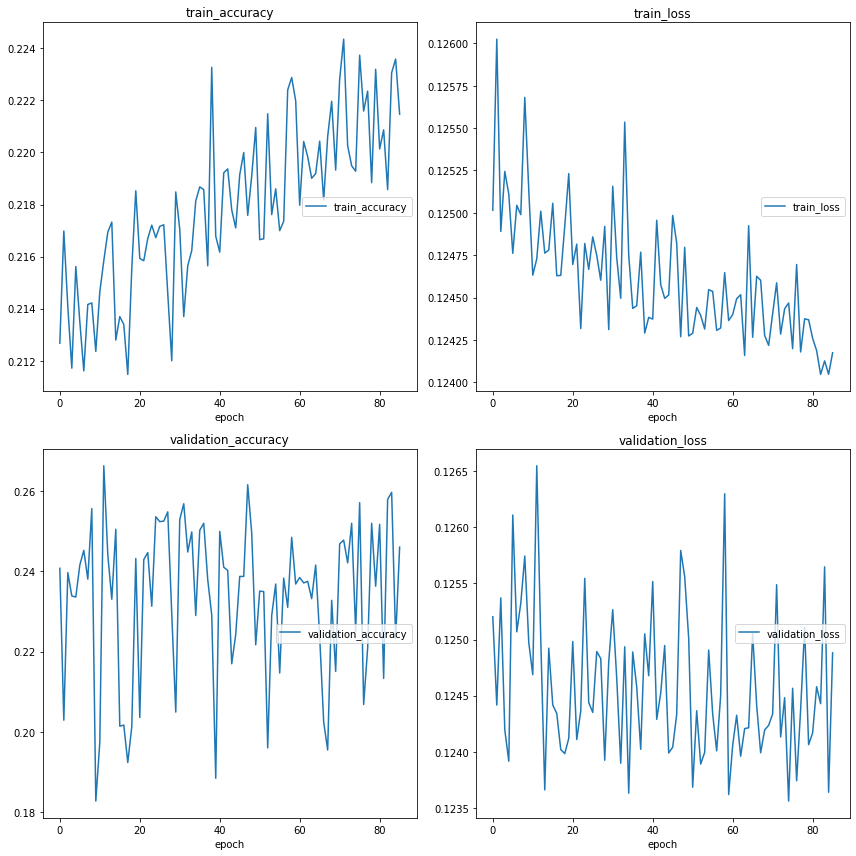

train_accuracy
	train_accuracy   	 (min:    0.211, max:    0.224, cur:    0.221)
train_loss
	train_loss       	 (min:    0.124, max:    0.126, cur:    0.124)
validation_accuracy
	validation_accuracy 	 (min:    0.183, max:    0.266, cur:    0.246)
validation_loss
	validation_loss  	 (min:    0.124, max:    0.127, cur:    0.125)


In [ ]:
for epoc in range(10000):

  train_loss, train_accuracy = train_epoc()
  validation_loss, val_accuracy = validation()

  liveloss.update({
          'train_loss': train_loss,
          'validation_loss': validation_loss,

          'train_accuracy': train_accuracy,
          'validation_accuracy': val_accuracy
      })
    
  liveloss.draw()

In [ ]:
# for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score  in o_data_loader:
#   break

# search_term = Variable(search_term).to(device)
# product_title = Variable(product_title).to(device)

# search_term_mask = Variable(search_term_mask).to(device)
# product_title_mask = Variable(product_title_mask).to(device)

search_term.shape

torch.Size([6, 15])

In [51]:


model.eval()
# test_scores = []
# test_ids =[]
# tt = []


with torch.no_grad():
  for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score in train_data_loader:
    search_term = Variable(search_term).to(device)
    search_term_mask = Variable(search_term_mask).to(device)
    product_title = Variable(product_title).to(device)
    product_title_mask = Variable(product_title_mask).to(device)
    
    scores = model(search_term, search_term_mask,  product_title, product_title_mask)

    res = torch.argmax(scores, dim=1)


    break
  

res



tensor([ 2, 10,  4, 12,  6, 12, 12, 12, 12, 12, 10, 10,  2, 12, 12, 12],
       device='cuda:0')

In [52]:
num_of_classes

13

In [52]:

i=1
tokenizer.decode(product_title[i].cpu().detach().numpy()), tokenizer.decode(search_term [i].cpu().detach().numpy())


('[CLS] talon temporary power outlet panel with 20, 30, 50 - amp receptacle surface mount - unmetered [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] 30 amp generater receptical [SEP] [PAD]')

In [57]:
# np.bincount(target_relevance_score.detach().numpy())
target_relevance_score

torch.Size([32])

In [345]:
df['index_pad'] = df['product_title_tokens'].apply(lambda x: x.index(0) if 0 in x else 50)

df[df['index_pad'] > 30].sample(10)[['product_title', "search_term"]]


,product_title,search_term
54955,Zamma Traditional Bamboo-Dark 5/8 in. Thick x ...,vinyl traditional
71463,"Com-Pak 1,000-Watt 120-Volt Fan-Forced In-Wall...",electric heaters with a thermostat
36931,Merola Tile Metro Hex 2 in. Matte White 10-1/2...,11 1/2x25 1/2 white aluminun
70772,Home Legend Kingsley Pine 5/8 in. Thick x 1 in...,innovations pine quarter round
69705,NoTrax Knee Rx Black 12 in. x 22 in. Nitrile R...,knurling
21966,Suncast 2 ft. 8 in. x 4 ft. 5 in. x 3 ft. 9.5 ...,resin shesd
58986,Daltile Union Square Courtyard Red 2 in. x 8 i...,red sparkle floor tile
52086,Design House 3-1/2 in. x 3-1/2 in. - 5/8 in. R...,bronze door hinge
73591,KOHLER Simplice 1 or 3-Hole Single Handle Pull...,stainless 1 hole faucet
24014,Smart Tiles 3-11/16 in. x 3-11/16 in. Slate Ge...,4 in smart tiles


In [346]:

for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score  in train_data_loader: #train_data_loader:
  break



In [376]:
#bert = BertModel.from_pretrained(RelevanceModel.BERT_MODEL_NAME, return_dict=True)
#bert.resize_token_embeddings(len(tokenizer))
from transformers import BertTokenizer, BertForSequenceClassification
# bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', output_hidden_states=True)

# b_out = bert(search_term)

b_out['hidden_states'][0].shape, b_out['hidden_states'][1].shape

(torch.Size([20, 10, 768]), torch.Size([20, 10, 768]))

In [ ]:
# 166693, len(test_data), len(test_df)
all_ids = {x for (x, _) in test_data}

for _, row in test_df.iterrows():
  if row['id'] not in all_ids:
    test_data.append((row['id'], 1))
    
len(test_data)

166693

In [ ]:
yy = df.sample(10)[['product_title', 'search_term', 'relevance', 'relevance_class', 'product_title_tokens', 'search_term_tokens']]
yy

,product_title,search_term,relevance,relevance_class,product_title_tokens,search_term_tokens
6952,Delta Porter 4 in. Centerset 2-Handle High-Arc Bathroom Faucet in Oil Rubbed Bronze,Bronze bath rug,1.00,5,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
6394,Husky 8-Pocket Nail Pouch,nail bags,2.67,3,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
34189,RIDGID JobMax 12-Volt Multi-Tool Starter Kit,ridgid 12 volt,3.00,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
23924,MOEN Brantford Tank Lever in Brushed Nickel,moen brantford nickel,3.00,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
14101,WeatherStar 36 in. x 55 in. 2-Track Storm Aluminum Window,Aluminum track for windows,2.00,4,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
65139,DEWALT Harsh Condition Insulated Size Large Work Glove,Insulted work gloves,3.00,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
33636,A-C Draftshields 12 in. x 12 in. Vent Cover,8x22 a/c vent,1.33,7,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
70402,Commercial Electric 2 in. 45å¡ Sch. 40 Belled End Elbow,2 pipe 45,3.00,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
57216,Commercial Electric 11 in. Cable Tie - Natural (100-Pack),commercial smart tie,2.33,2,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
20838,Nature Power Bayport 72 in. Black Outdoor Solar Lamp Post with Super Bright Natural White LED,post lamp tier,2.67,3,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
i = 0
yy.iloc[i]['product_title'], tokenizer.convert_ids_to_tokens(yy.iloc[i]['product_title_tokens']['input_ids'])

('Delta Porter 4 in. Centerset 2-Handle High-Arc Bathroom Faucet in Oil Rubbed Bronze',
 ['[CLS]',
  'delta',
  'porter',
  '4',
  'in',
  '.',
  'centers',
  '##et',
  '2',
  '-',
  'handle',
  'high',
  '-',
  'arc',
  'bathroom',
  'fa',
  '##uce',
  '##t',
  'in',
  'oil',
  'rubbed',
  'bronze',
  '[SEP]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[P